This section is responsible for setting up  correct environment

Run it and restart runtime

In [1]:
!pip install --user --upgrade tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Here all necessary imports happen

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import tensorflow_model_optimization as tfmot
import tempfile
import keras

# making directory if necessairy
!mkdir /content/gdrive/My\ Drive/Colab_Models/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘/content/gdrive/My Drive/Colab_Models/’: File exists


Auxiliary code responsible for notebook features

In [3]:
def load_data():
  # loading the data
  (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


  # normalization to [0;1] range
  train_images, test_images = train_images / 255.0, test_images / 255.0

  #names of classes
  class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',  'dog', 'frog', 'horse', 'ship', 'truck']
  return train_images, train_labels, test_images, test_labels, class_names

def print_result(labels, array_of_history):
  #showing example figures
  plt.figure(figsize=(10,10))
  for i in range(len(labels)):
      plt.subplot(5,5,i+1)
      history = array_of_history[i]
      plt.plot(history.history['accuracy'], label='accuracy')
      plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.ylim([0.5, 1])
      plt.legend(loc='lower right')
      plt.title(labels[i])
  plt.show()

def visualize_prunning(history, title):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')
  plt.title(title)
  plt.show()

def loadModel(file_path):
  return keras.models.load_model('/content/gdrive/My Drive/Colab_Models/'+file_path)

def prepare_for_pruning(model_loaded, pruning_params):
  model_for_pruning = prune_low_magnitude(model_loaded, **pruning_params)
  model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  model_for_pruning.summary()
  return model_for_pruning

Parameters

In [4]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
VALIDATION_SPLIT = 0.1 # % of training set will be used for validation set.
EPOCHS=6
BATCH_SIZE=64

INITIAL_SPARSITY = 0.3
FINAL_SPARSITY = 0.4

MODEL_FILE_PATH = "model_test1_arch7_run1_.h5"

PRUNING_TEST_NAME = "prunning-arch7-p1"
MODEL_FILE_EXT = ".h5"

Prunning

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 32, 32, 32)       1762      
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_conv2d_  (None, 32, 32, 32)       18466     
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 16, 16, 32)       1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 16, 16, 64)       36930     
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d_  (None, 16, 16, 64)       7

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 730s 462ms/step - loss: 0.3188 - accuracy: 0.8892 - val_loss: 0.8236 - val_accuracy: 0.7736
Epoch 2/6
1563/1563 [==============================] - 739s 473ms/step - loss: 0.2526 - accuracy: 0.9108 - val_loss: 0.8417 - val_accuracy: 0.7763
Epoch 3/6
1563/1563 [==============================] - 716s 458ms/step - loss: 0.2104 - accuracy: 0.9259 - val_loss: 0.8824 - val_accuracy: 0.7794
Epoch 4/6
1563/1563 [==============================] - 741s 474ms/step - loss: 0.1938 - accuracy: 0.9336 - val_loss: 0.9926 - val_accuracy: 0.7711
Epoch 5/6
1563/1563 [==============================] - 740s 473ms/step - loss: 0.1813 - accuracy: 0.9378 - val_loss: 1.0066 - val_accuracy: 0.7789
Epoch 6/6
1563/1563 [==============================] - 730s 467ms/step - loss: 0.1648 - accuracy: 0.9437 - val_loss: 1.0487 - val_accuracy: 0.7724
313/313 - 29s - loss: 1.0487 - accuracy: 0.7724 - 29s/epoch - 92ms/step
Eval loss: 1.0486979484558105 Eval accuracy: 0.772400021

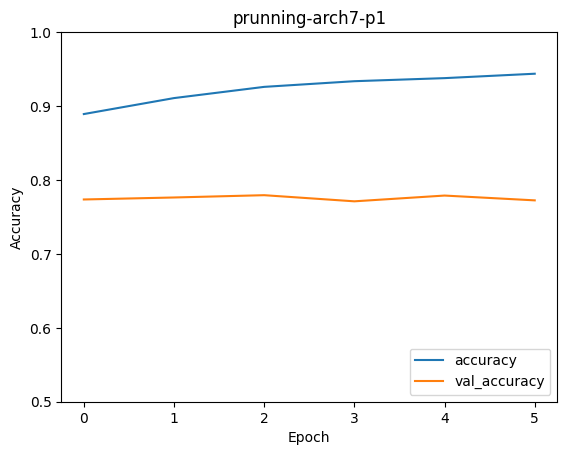

In [5]:
train_images, train_labels, test_images, test_labels, class_names = load_data()

num_images = train_images.shape[0] * (1 - VALIDATION_SPLIT)
end_step = np.ceil(num_images / BATCH_SIZE).astype(np.int32) * EPOCHS

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=INITIAL_SPARSITY,
                                                               final_sparsity=FINAL_SPARSITY,
                                                               begin_step=0,
                                                               end_step=end_step)
}

base_model = loadModel(MODEL_FILE_PATH)
model_for_pruning = prepare_for_pruning(base_model, pruning_params)

logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

history = model_for_pruning.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=EPOCHS, callbacks=callbacks)

model_for_pruning.save('/content/gdrive/My Drive/Colab_Models/'+PRUNING_TEST_NAME+MODEL_FILE_EXT)

test_loss, test_acc = model_for_pruning.evaluate(test_images,  test_labels, verbose=2)
print("Eval loss:", test_loss, "Eval accuracy:", test_acc)

visualize_prunning(history, PRUNING_TEST_NAME)